In [3]:
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pylab as plt
from scipy.linalg import fractional_matrix_power

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

## Data

In [4]:
data = pd.read_csv('data/X_train.csv', index_col=0, sep=',')
data.columns.name = 'date'

In [5]:
print(f'Shape of data: {data.shape}')

Shape of data: (50, 754)


## Theory

Suppose we have the returns, $R\in\mathbb{R}^{N\times T}$, where $N=50$ and $T=754$. The goal is to find a $d$-dimensional embedding, where $d<N$, such that the error 

$$
e = \sum_{t}||R_{t+\tau} - KR_{t}||_{2}^{2}
$$

is minimum. $K$ is the Koopman operator and can be rewritten as 

$$
K = DE
$$

where $D$ is the decoder and $E$ is the encoder. 

### Mean-free Coordinates
For a single return, $r_{t}$, 

$$
x_{t} = r_{t} - \dfrac{1}{T-\tau}\sum_{s=1}^{T-\tau}r_{s}
$$

and 

$$
y_{t} = r_{t+\tau} - \dfrac{1}{T-\tau}\sum_{s=1}^{T-\tau}r_{s+\tau} 
$$

### Pre-Whitening

$$
\tilde{x}_{t} = L_{xx}^{-1}x_{t}
$$

$$
\tilde{y}_{t} = L_{yy}^{-1}y_{t}
$$

where the covariances and Cholesky factors are:

$$
C_{xx} = \dfrac{1}{T-\tau}XX^{T}
$$

$$
C_{yy} = \dfrac{1}{T-\tau}YY^{T}
$$

$$
C_{xy} = \dfrac{1}{T-\tau}XY^{T}
$$

where $X\in\mathbb{R}^{N\times(T-\tau)}$ and $Y\in\mathbb{R}^{N\times(T-\tau)}$ and $C_{xx}=L_{xx}L_{xx}^{T}$ and $C_{yy}=L_{yy}L_{yy}^{T}$

### Koopman Matrix in the Pre-whitened Space

If we denote the pre-whitened (time-lagged) returns as $\tilde{X}$ and $\tilde{Y}$, we want to find $\tilde{K}$ such that the error 

$$
||\tilde{Y} - \tilde{K}\tilde{X}||_{2}^{2}
$$

is minimum. This has an analytical solution:

$$
\tilde{K} = \tilde{Y}\tilde{X}^{T}(\tilde{X}\tilde{X}^{T})^{-1}.
$$

<ins>Finding the encoder and decoder</ins>

We can use SVD to find the encoder and decoder of the Koopman operator in the transformed space. 

$$
\tilde{K} = U\Sigma V^{T}
$$

and if we retain the top $d$ components, 

$$
\tilde{E} = \Sigma_{d}V_{d}^{T}
$$

$$
\tilde{D} = U_{d}
$$

where $\tilde{E}\in\mathbb{R}^{d\times N}$ and $\tilde{D}\in\mathbb{R}^{N\times d}$. In the original space, we can show that the Koopman operator, the decoder and the encoder are:

$$
K = C_{xy}^{T}C_{xx}^{-1}
$$

$$
D = L_{yy}\tilde{D}
$$

$$
E = \tilde{E}L_{xx}^{-1}
$$

## Functions

In [6]:
TAU = 250
NCOMPONENTS = 15
NTIME = data.shape[1]
NSTOCK = data.shape[0]
NWINDOW = NTIME - TAU

In [25]:
def create_time_lagged(dataframe: pd.DataFrame, lags: int = 250) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Creates time-lagged versions of the input dataframe.

    Args:
        dataframe (pd.DataFrame): Input dataframe with time series data.
        lags (int, optional): Number of lags to apply. Defaults to 250.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Time-lagged matrices (X, Y).
    """
    dataframe = dataframe.copy()
    nstock, ndata = dataframe.shape
    x_matrix = dataframe.iloc[:, 0:ndata - lags]
    y_matrix = dataframe.iloc[:, lags:]

    # print(f'Shape of x_matrix: {x_matrix.shape}')
    # print(f'Shape of y_matrix: {y_matrix.shape}')

    return x_matrix, y_matrix

def compute_covariance_matrices(x_matrix: np.ndarray,
                                y_matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes covariance matrices cov_xx, cov_xy, and cov_yy.

    Args:
        x_matrix (np.ndarray): Past states matrix of shape (d, N).
        y_matrix (np.ndarray): Future states matrix of shape (d, N).

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        Covariance matrices (cov_xx, cov_xy, cov_yy) and mean vectors (x_mean, y_mean).
    """
    T_tau = x_matrix.shape[1]

    x_mean = np.mean(x_matrix, axis=1, keepdims=True)
    y_mean = np.mean(y_matrix, axis=1, keepdims=True)
    x_values = x_matrix - x_mean
    y_values = y_matrix - y_mean

    cov_xx = (1 / T_tau) * (x_values @ x_values.T)
    cov_xy = (1 / T_tau) * (x_values @ y_values.T)
    cov_yy = (1 / T_tau) * (y_values @ y_values.T)

    return cov_xx, cov_xy, cov_yy, x_mean, y_mean

def compute_cholesky(covariance: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the Cholesky decomposition of a covariance matrix.

    Args:
        covariance (np.ndarray): Input covariance matrix.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Cholesky decomposition and its inverse.
    """
    chol = np.linalg.cholesky(covariance)
    inv_chol = np.linalg.inv(chol)
    return chol, inv_chol

def scale_data(dataframe: pd.DataFrame,
               covariance: np.ndarray,
               mean: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Scales data using the Cholesky decomposition of the covariance matrix.

    Args:
        dataframe (pd.DataFrame): Input dataframe.
        covariance (np.ndarray): Covariance matrix.
        mean (np.ndarray): Mean vector.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Scaled data, Cholesky factor, and inverse Cholesky factor.
    """
    dataframe = dataframe.copy()
    cholesky, inv_cholesky = compute_cholesky(covariance)
    scaled_data = inv_cholesky @ (dataframe - mean)
    return scaled_data, cholesky, inv_cholesky


def inv_scale_data(scaled_data: np.ndarray,
                   cholesky: np.ndarray,
                   mean: np.ndarray) -> np.ndarray:
    """
    Inversely scales data using the Cholesky decomposition of the covariance matrix.

    Args:
        scaled_data (np.ndarray): Scaled data.
        cholesky (np.ndarray): Cholesky factor.
        mean (np.ndarray): Mean vector.

    Returns:
        np.ndarray: Inversely scaled data.
    """
    return cholesky @ scaled_data + mean

def whitened_koopman(scaled_x: pd.DataFrame, scaled_y: pd.DataFrame) -> np.ndarray:
    """
    Computes the whitened Koopman operator.

    Args:
        scaled_x (pd.DataFrame): Scaled past states.
        scaled_y (pd.DataFrame): Scaled future states.

    Returns:
        np.ndarray: Koopman operator matrix.
    """
    scaled_x_val = scaled_x.values
    scaled_y_val = scaled_y.values
    prod = scaled_y_val @ scaled_x_val.T
    inv = np.linalg.inv(scaled_x_val @ scaled_x_val.T)
    koopman = prod @ inv
    return koopman

def dec_enc_whitened(koopman: np.ndarray, ncomponents: int = 10) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the rank-d approximation of the Koopman matrix using SVD.

    Args:
        koopman (np.ndarray): Whitened Koopman matrix.
        ncomponents (int, optional): Target dimensionality. Defaults to 10.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Encoding and decoding matrices.
    """
    U_matrix, Sigma_matrix, V_trans_matrix = np.linalg.svd(koopman, full_matrices=False)
    U_d = U_matrix[:, :ncomponents]
    Sigma_d = np.diag(Sigma_matrix[:ncomponents])
    V_d = V_trans_matrix[:ncomponents, :]

    decoder = U_d
    encoder = Sigma_d @ V_d
    return decoder, encoder

def nonwhitened_koopman(cov_xy: np.ndarray, cov_xx: np.ndarray) -> np.ndarray:
    """
    Computes the non-whitened Koopman operator.

    Args:
        cov_xy (np.ndarray): Cross-covariance matrix.
        cov_xx (np.ndarray): Autocovariance matrix.

    Returns:
        np.ndarray: Non-whitened Koopman operator.
    """
    return cov_xy.T @ np.linalg.inv(cov_xx)

def dec_enc_nonwhitened(chol_yy: np.ndarray,
                        inv_chol_xx: np.ndarray,
                        decoder: np.ndarray,
                        encoder: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Converts whitened encoder and decoder matrices to their non-whitened forms.

    Args:
        chol_yy (np.ndarray): Cholesky factor of covariance matrix yy.
        inv_chol_xx (np.ndarray): Inverse Cholesky factor of covariance matrix xx.
        decoder (np.ndarray): Whitened decoder matrix.
        encoder (np.ndarray): Whitened encoder matrix.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Non-whitened decoder and encoder matrices.
    """
    decoder_nonwhitened = chol_yy @ decoder
    encoder_nonwhitened = encoder @ inv_chol_xx
    return decoder_nonwhitened, encoder_nonwhitened

def compute_metric(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """
    Computes a similarity metric between predicted and true values.

    Args:
        y_pred (np.ndarray): Predicted values.
        y_true (np.ndarray): Ground truth values.

    Returns:
        float: Mean similarity metric.
    """
    y_pred_scaled = y_pred / np.linalg.norm(y_pred, axis=0, keepdims=True)
    y_true_scaled = y_true / np.linalg.norm(y_true, axis=0, keepdims=True)
    total = np.sum(y_pred_scaled * y_true_scaled, axis=0)
    return np.mean(total)

def compute_prediction(x_matrix: pd.DataFrame, dec_non: np.ndarray, enc_non: np.ndarray) -> np.ndarray:
    """
    Computes predictions using the Koopman model.

    Args:
        x_matrix (pd.DataFrame): Input matrix.
        dec_non (np.ndarray): Non-whitened decoder matrix.
        enc_non (np.ndarray): Non-whitened encoder matrix.

    Returns:
        np.ndarray: Predicted values.
    """
    return dec_non @ (enc_non @ x_matrix.values)


## Create the dataset

In [8]:
x_matrix, y_matrix = create_time_lagged(data, lags=TAU)

Shape of x_matrix: (50, 504)
Shape of y_matrix: (50, 504)


In [9]:
cov_xx, cov_xy, cov_yy, mean_x, mean_y = compute_covariance_matrices(x_matrix.values, y_matrix.values)

In [10]:
scaled_x, chol_xx, inv_chol_xx = scale_data(x_matrix, cov_xx, mean_x)
scaled_y, chol_yy, inv_chol_yy = scale_data(y_matrix, cov_yy, mean_y)

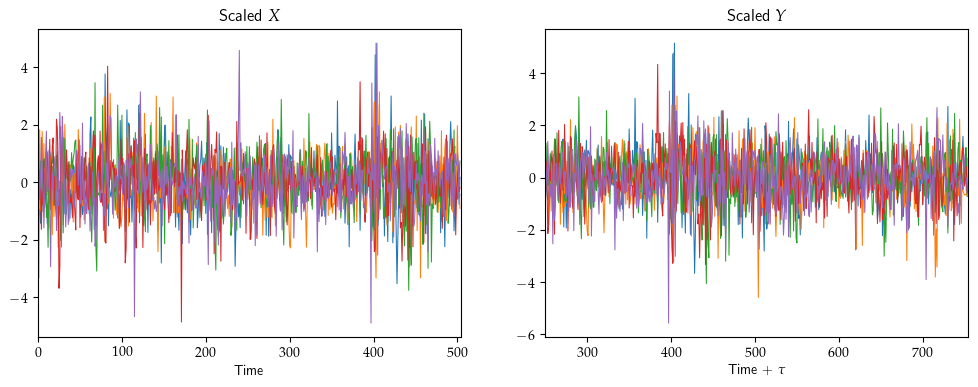

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(r'Scaled $X$')
for i in range(5):
    plt.plot(range(NWINDOW), scaled_x.iloc[i].values, lw = 0.75)
plt.xlim(0, NWINDOW)
plt.xlabel('Time')
plt.subplot(122)
plt.title(r'Scaled $Y$')
for i in range(5):
    plt.plot(range(TAU, NTIME), scaled_y.iloc[i].values, lw = 0.75)
plt.xlabel(r'Time + $\tau$')
plt.xlim(TAU, NTIME)
plt.show()

## Calculate Koopman Matrix

In [12]:
koop_whitened = whitened_koopman(scaled_x, scaled_y)
dec_whitened, enc_whitened = dec_enc_whitened(koop_whitened, ncomponents=NCOMPONENTS)

In [13]:
koop_nonwhitened = nonwhitened_koopman(cov_xy, cov_xx)
dec_nonwhitened, enc_nonwhitened = dec_enc_nonwhitened(chol_yy, inv_chol_xx, dec_whitened, enc_whitened)

In [14]:
y_pred = compute_prediction(x_matrix, dec_nonwhitened, enc_nonwhitened)
metric = compute_metric(y_pred, y_matrix.values)

In [15]:
print(f'Correlation metric is: {metric:.4f}')

Correlation metric is: 0.2401


## Correlation Metric as a function of $\tau$

In [ ]:
def corr_metric_tau(data: pd.DataFrame, tau: int) -> float:
    """Computes a correlation-based metric for a given time lag tau.

    This function creates time-lagged data matrices and computes covariance matrices.
    It then applies data scaling, computes Koopman operators (both whitened and non-whitened),
    and ultimately evaluates a prediction metric.

    Args:
        data (pd.DataFrame): Input time-series data.
        tau (int): Time lag to use for creating lagged data.

    Returns:
        float: Computed metric value.
    """
    x_matrix, y_matrix = create_time_lagged(data, lags=tau)
    cov_xx, cov_xy, cov_yy, mean_x, mean_y = compute_covariance_matrices(x_matrix.values, y_matrix.values)

    # scale the data
    scaled_x, chol_xx, inv_chol_xx = scale_data(x_matrix, cov_xx, mean_x)
    scaled_y, chol_yy, inv_chol_yy = scale_data(y_matrix, cov_yy, mean_y)

    # compute the covariance matrices
    koop_whitened = whitened_koopman(scaled_x, scaled_y)
    dec_whitened, enc_whitened = dec_enc_whitened(koop_whitened, ncomponents=NCOMPONENTS)

    # compute the non-whitened covariance matrices
    koop_nonwhitened = nonwhitened_koopman(cov_xy, cov_xx)
    dec_nonwhitened, enc_nonwhitened = dec_enc_nonwhitened(chol_yy, inv_chol_xx, dec_whitened, enc_whitened)

    # compute the prediction and the metric
    y_pred = compute_prediction(x_matrix, dec_nonwhitened, enc_nonwhitened)
    metric = compute_metric(y_pred, y_matrix.values)

    return metric

In [37]:
tau_values = np.arange(1, 251, 1)
metrics = []
for tau in tau_values:
    metric = corr_metric_tau(data, tau)
    metrics.append(metric)

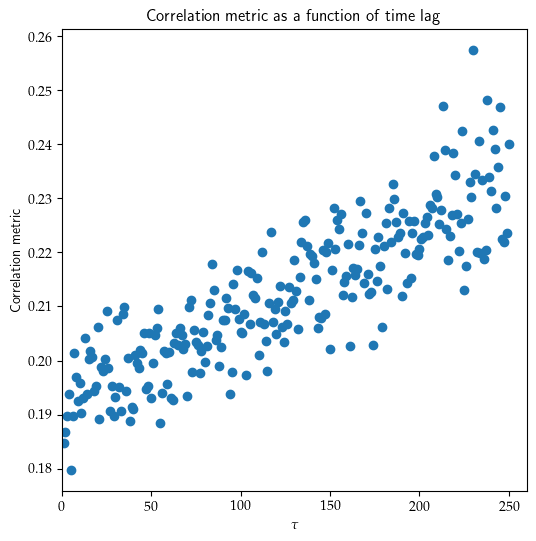

In [38]:
plt.figure(figsize=(6, 6))
plt.scatter(tau_values, metrics)
plt.xlabel(r'$\tau$')
plt.ylabel('Correlation metric')
plt.title('Correlation metric as a function of time lag')
plt.xlim(0, max(tau_values)+10)
plt.show()

## Factors 

The factors in this case can be thought of as being:

$$
F = EX
$$

In [15]:
factors = enc_nonwhitened @ x_matrix

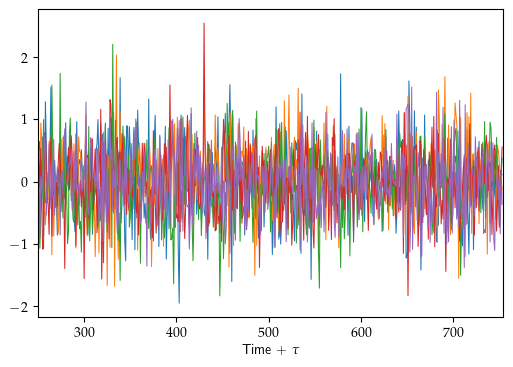

In [16]:
plt.figure(figsize=(6,4))
for i in range(5):
    plt.plot(range(TAU, NTIME), factors.iloc[i].values, lw = 0.75)
plt.xlim(TAU, NTIME)
plt.xlabel(r'Time + $\tau$')
plt.show()

## Autoencoder

Create a time-lagged autoencoder. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [86]:
class TimeLaggedAutoencoder(nn.Module):
    def __init__(self, num_stocks=50,
                 latent_dim=10,
                 hidden_dim1=200,
                 hidden_dim2=100,
                 dropout_prob=0.5,
                 leaky_relu_alpha=0.001):
        super(TimeLaggedAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(num_stocks, hidden_dim1),
            nn.LeakyReLU(negative_slope=leaky_relu_alpha),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(negative_slope=leaky_relu_alpha),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim2, latent_dim)
        )

        # Latent Activation (only applied during training)
        self.latent_activation = nn.LeakyReLU(negative_slope=leaky_relu_alpha)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.LeakyReLU(negative_slope=leaky_relu_alpha),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.LeakyReLU(negative_slope=leaky_relu_alpha),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim1, num_stocks)
        )

    def forward(self, x):
        x = self.encoder(x)
        if self.training:
            x = self.latent_activation(x)
        x = self.decoder(x)
        return x

In [87]:
def correlation_loss(y_pred: Tensor, y_true: Tensor) -> Tensor:
    """Computes the negative correlation loss.

    Args:
        y_pred (Tensor): Predicted output tensor.
        y_true (Tensor): Ground truth tensor.

    Returns:
        Tensor: Negative correlation loss.
    """
    num = torch.sum(y_pred * y_true, dim=0)
    denom = torch.norm(y_pred, dim=0) * torch.norm(y_true, dim=0)
    return -torch.mean(num / denom)

In [88]:
BATCH_SIZE = 64
NUM_EPOCHS = 5000
PRINT_FREQ = 10
PRINT_THRESH = NUM_EPOCHS // 10

In [89]:
X_tensor = torch.tensor(scaled_x.values.T, dtype=torch.float32)
Y_tensor = torch.tensor(scaled_y.values.T, dtype=torch.float32)

train_dataset = TensorDataset(X_tensor, Y_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [90]:
model = TimeLaggedAutoencoder(num_stocks=scaled_x.shape[0],
                              latent_dim=NCOMPONENTS)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
%%capture
model.to(device)

In [92]:
record_loss = []
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        # loss = correlation_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    if (epoch + 1) % PRINT_THRESH == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss/len(train_loader):.4f}")
    record_loss.append(epoch_loss/len(train_loader))

Epoch [500/5000], Loss: 0.8699
Epoch [1000/5000], Loss: 0.8571
Epoch [1500/5000], Loss: 0.8289
Epoch [2000/5000], Loss: 0.8278
Epoch [2500/5000], Loss: 0.8132
Epoch [3000/5000], Loss: 0.7921
Epoch [3500/5000], Loss: 0.7884
Epoch [4000/5000], Loss: 0.7970
Epoch [4500/5000], Loss: 0.8040
Epoch [5000/5000], Loss: 0.7908


In [93]:
with torch.no_grad():
    X_encoded = model.encoder(X_tensor.to(device))

In [94]:
y_pred_net = model(X_tensor.to(device)).detach().cpu().numpy()
y_pred_net_scaled = inv_scale_data(y_pred_net.T, chol_yy, mean_y)
metric_tae = compute_metric(y_pred_net_scaled, y_matrix.values)

In [95]:
print(f'Correlation metric is: {metric_tae:.4f}')

Correlation metric is: 0.3590


In [ ]:
# MSE loss: 0.3590
# correlation loss: 0.3768